# 10/22/2015

# Beginning Analysis of Red Disk Fraction over Redshift, starting by using Tom's selection Method


# Section 1: Cross-matching with ULTRAVISTA catalog
## ULTRAVISTA provides k-corrected colors and magnitudes for 339,384 galaxies in the COSMOS field. GZ:Hubble classified 84,350 galaxies in the COSMOS field. Of these, 70,198 were sky-matched in the ULTRAVista catalog (with a max. separation of 1"). 

## link to ULTRAVista data: http://terapix.iap.fr/article.php?id_article=844

 

In [36]:
%pylab inline
import matplotlib.gridspec as gridspec
import scipy.stats.distributions as dist
from matplotlib import ticker

from scipy.optimize import curve_fit
from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
mpl.rcParams['text.usetex']=True


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [37]:
data = pyfits.open('/home/mel/Documents/GZ_HUBBLE/other_catalogs/ULTRAVISTA/matched_catalog.fits')
data=data[1].data

In [38]:
#update redshift column to take the best version
z='Z_BEST_COMBINED'

In [39]:
data_2_1 = (data[z]>=.2) & (data[z]<=1) 
print 'The number of galaxies in COSMOS between $0.2 < z < 1.0$ is %s'%len(data[data_2_1])


The number of galaxies in COSMOS between $0.2 < z < 1.0$ is 52707


# Section 2: Removing Dusty Galaxies
# Galaxies so far (UV + GZH + 0.2 < z < 1.0): 52,707
## a note: the NUV-MR column in the UV table is a lie...somehow? physically subtracting the MR from NUV column gives the correct values. 

In [43]:
correctable_data=(data['Correctable_Category']=='correctable') 

In [7]:
data_2_4 = (data[z]>=0.2) & (data[z]<=.4)# & (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)
data_4_6 = (data[z]>0.4) & (data[z]<=.6) #& (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)
data_6_8 = (data[z]>0.6) & (data[z]<=.8) #& (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)
data_8_1 = (data[z]>0.8) & (data[z]<=1) #& (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=.8)


In [8]:
data_2_4_red = (data[z]>=0.2) & (data[z]<=.4) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<(1.6+2.2*(data['MR']-data['MJ'])))
data_4_6_red = (data[z]>0.4) & (data[z]<=.6) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<1.6+2.2*(data['MR']-data['MJ']))
data_6_8_red = (data[z]>0.6) & (data[z]<=.8) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<1.6+2.2*(data['MR']-data['MJ']))
data_8_1_red = (data[z]>0.8) & (data[z]<=1) & (data['MNUV']-data['MR']>4) & (data['MNUV']-data['MR']<1.6+2.2*(data['MR']-data['MJ']))

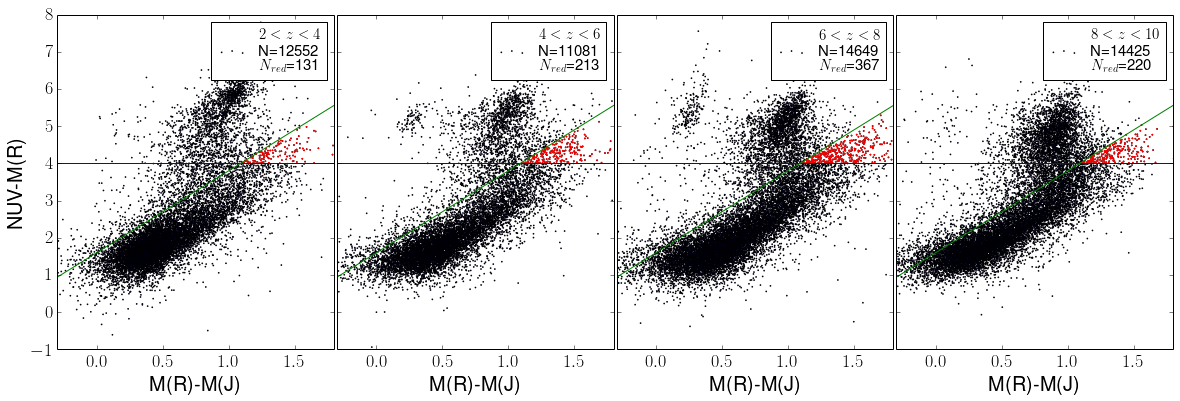

In [9]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(20,6))
gs=gridspec.GridSpec(1,4)
gs.update(wspace=.01)

data_list=[data_2_4,data_4_6,data_6_8,data_8_1]
data_list_red=[data_2_4_red,data_4_6_red,data_6_8_red,data_8_1_red]

labellist=[2,4,6,8]

x=np.linspace(-1,2,10)
for i in range(0,4):
    ax=plt.subplot(gs[0,i])
    plt.scatter(data[data_list[i]]['MR']-data[data_list[i]]['MJ'],data[data_list[i]]['MNUV']-data[data_list[i]]['MR'],s=.5,label='$%s<z<%s$\nN=%s\n$N_{red}$=%s'%(labellist[i],labellist[i]+2,len(data[data_list[i]]),len(data[data_list_red[i]])))
    plt.scatter(data[data_list_red[i]]['MR']-data[data_list_red[i]]['MJ'],data[data_list_red[i]]['MNUV']-data[data_list_red[i]]['MR'],s=.5,color='r')

    if i!=0:
        plt.tick_params(labelleft='off')
    plt.xlim(-.3,1.8)
    plt.ylim(-1,8)
    plt.xlabel('M(R)-M(J)',fontsize=20)
    if i==0:
        plt.ylabel('NUV-M(R)',fontsize=20)
    plt.legend(numpoints=1,fontsize=15)
    plt.plot(x,4+0*x)
    plt.plot(x,1.6+2.2*x)



In [6]:
red_cut = (data['MNUV']-data['MR']<4) | (data['MNUV']-data['MR']>(1.6+2.2*(data['MR']-data['MJ'])))

data_2_1_red = (data[z]>=0.2) & (data[z]<=1) & red_cut
print 'The number of galaxies after removing dusty galaxies is %s' %len(data[data_2_1_red])

The number of galaxies after removing dusty galaxies is 51774


# Section 3a - Surface Brightness Cut 
## I'm not sure exactly what the best route is here - magnitude or surface brightness. Will try both for now?

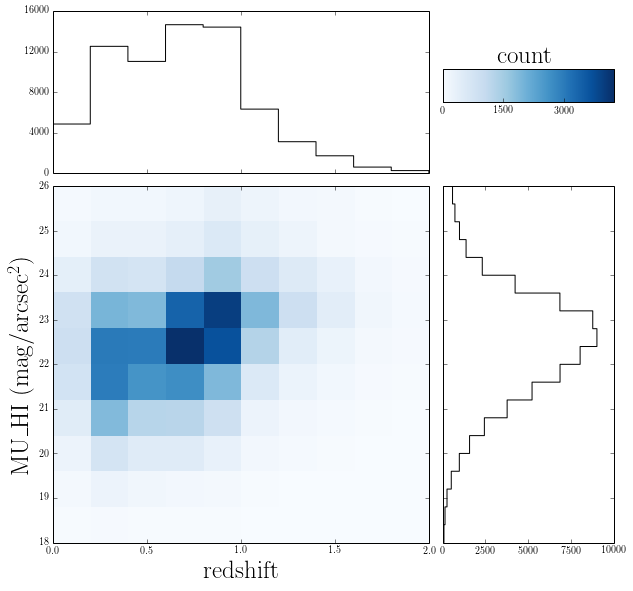

In [7]:
left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width+0.02

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

xlabel = '$\mathrm{redshift}$'
ylabel = '$\mathrm{MU\_HI~(mag/arcsec^2)}$'


fig = plt.figure(1, figsize=(9.5,9))

axTemperature = plt.axes(rect_temperature) # temperature plot
axHistx = plt.axes(rect_histx) # x histogram
axHisty = plt.axes(rect_histy) # y histogram

nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

hist,xedges,yedges=np.histogram2d(data[z],data['MU_HI'],range=((0,2),(18,26)))

extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

cax = axTemperature.imshow(hist.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues)
axHistx.hist(data[z], color = 'k',histtype='step',range=(0,2))
axHisty.hist(data['MU_HI'],orientation='horizontal', color = 'k',histtype='step',range=(18,26),bins=20)

axHisty.xaxis.set_major_locator(MaxNLocator(4))
axHistx.yaxis.set_major_locator(MaxNLocator(4))

axTemperature.set_xlabel(xlabel,fontsize=25)
axTemperature.set_ylabel(ylabel,fontsize=25)


cbaxes = fig.add_axes([0.69, 0.8, 0.25, 0.05]) 
cb = plt.colorbar(cax, cax = cbaxes,orientation='horizontal') 
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

fig.text(.77,.86,'$\mathrm{count}$',fontsize=25)
 
plt.savefig('SB_vs_redshift.png')

In [30]:
SB_cut = (data['MR']<-21)
new_sample = (data[z]>=0.2) & (data[z]<=1) & red_cut & SB_cut
print 'Galaxies remaining after applying surface brightness cut: %s'%len(data[new_sample])

Galaxies remaining after applying surface brightness cut: 18954


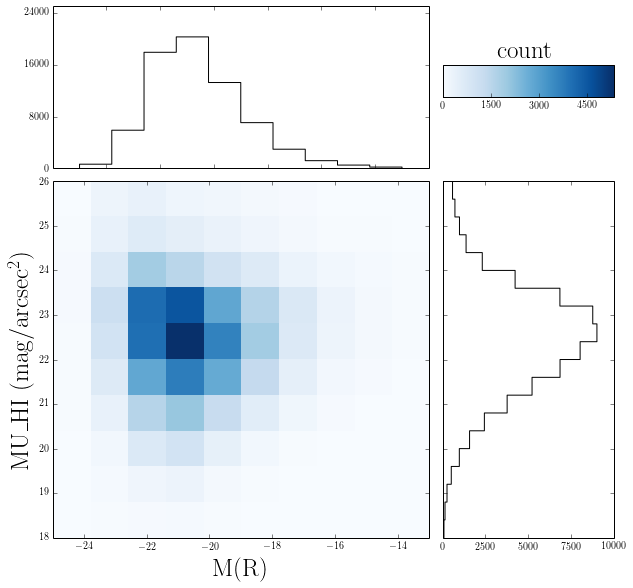

In [8]:
left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width+0.02

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

xlabel = '$\mathrm{M(R)}$'
ylabel = '$\mathrm{MU\_HI~(mag/arcsec^2)}$'


fig = plt.figure(1, figsize=(9.5,9))

axTemperature = plt.axes(rect_temperature) # temperature plot
axHistx = plt.axes(rect_histx) # x histogram
axHisty = plt.axes(rect_histy) # y histogram

nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

hist,xedges,yedges=np.histogram2d(data['MR'],data['MU_HI'],range=((-25,-13),(18,26)))

extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]

cax = axTemperature.imshow(hist.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues)
axHistx.hist(data['MR'], color = 'k',histtype='step',range=(-25,-13))
axHisty.hist(data['MU_HI'],orientation='horizontal', color = 'k',histtype='step',range=(18,26),bins=20)

axHisty.xaxis.set_major_locator(MaxNLocator(4))
axHistx.yaxis.set_major_locator(MaxNLocator(4))

axTemperature.set_xlabel(xlabel,fontsize=25)
axTemperature.set_ylabel(ylabel,fontsize=25)


cbaxes = fig.add_axes([0.69, 0.8, 0.25, 0.05]) 
cb = plt.colorbar(cax, cax = cbaxes,orientation='horizontal') 
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

fig.text(.77,.86,'$\mathrm{count}$',fontsize=25)
 
plt.savefig('MR_vs_SB.png')

# Section 3b - Magnitude cut (using Tom's method)
## Plot Mr vs z, find separation between where features are no longer detectable

In [34]:
def zHist3D(xedges,yedges,the_data,colorhist,p):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MR']>=yedges[i]) & (the_data['MR'] < yedges[i+1]) & (the_data[z]>=xedges[j]) & (the_data[z]<xedges[j+1])
            newmatrix[i,j]=np.nanmean(the_data[data_i_j][p])
    newmatrix=ma.masked_where(colorhist.T<50,newmatrix)
    return newmatrix

def zHist3D_SB(xedges,yedges,the_data,colorhist,p):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MU_HI']>=yedges[i]) & (the_data['MU_HI'] < yedges[i+1]) & (the_data[z]>=xedges[j]) & (the_data[z]<xedges[j+1]) 
            newmatrix[i,j]=np.nanmean(the_data[data_i_j][p])
    newmatrix=ma.masked_where(colorhist.T<50,newmatrix)
    return newmatrix

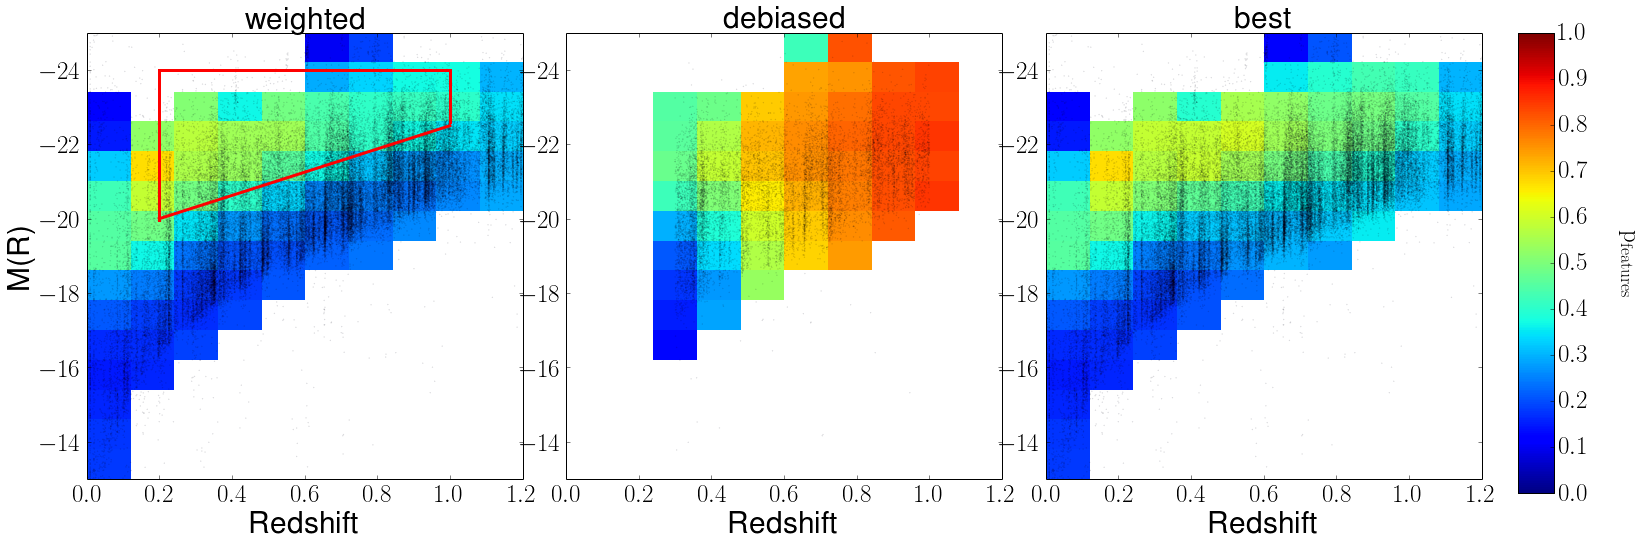

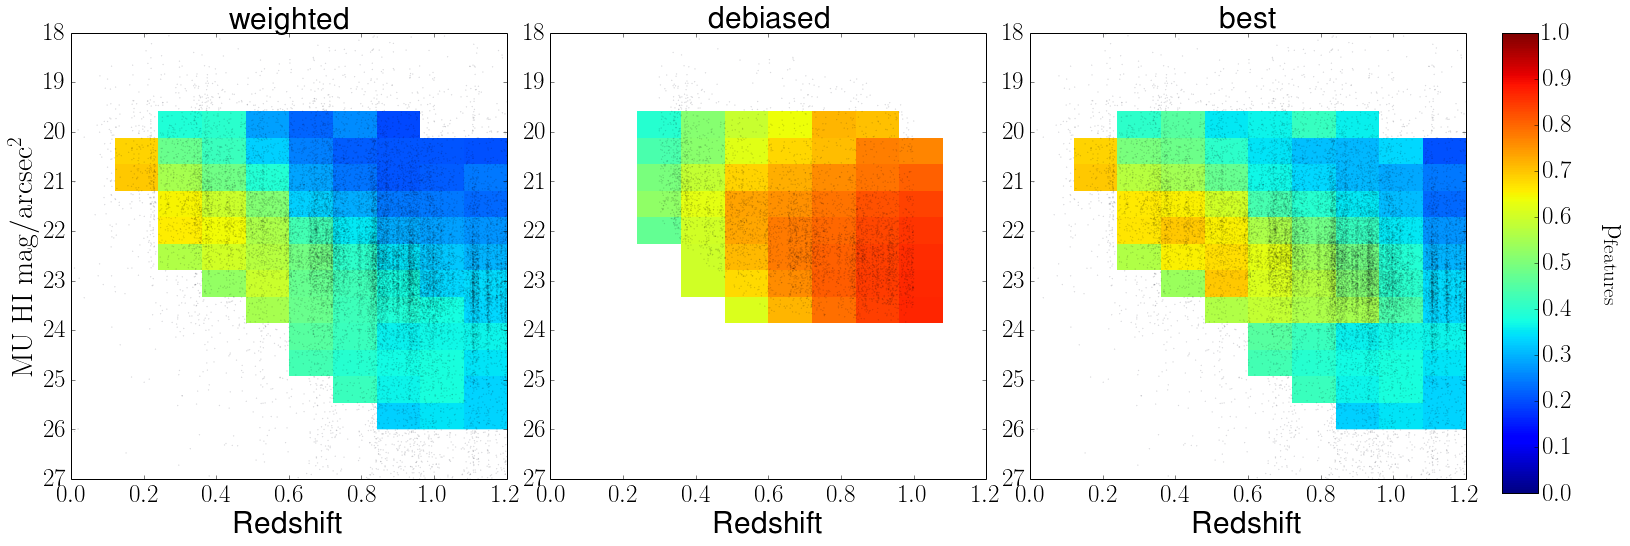

In [48]:
maghist,xedges,yedges = np.histogram2d(data[z],data['MR'],range=((0,1.2),(-25,-13)),bins=(10,15))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist_weighted=zHist3D(xedges,yedges,data,maghist,'t01_smooth_or_features_a02_features_or_disk_weighted_fraction')
this_hist_debiased=zHist3D(xedges,yedges,data[correctable_data],maghist,'t01_smooth_or_features_a02_features_or_disk_debiased_fraction')
this_hist_best=zHist3D(xedges,yedges,data,maghist,'t01_smooth_or_features_a02_features_or_disk_best_fraction')

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

cmap=cm.jet

f=plt.figure(figsize=(25,8))
gs=gridspec.GridSpec(1,3)
gs.update(wspace=.1,hspace=0)

ax1=plt.subplot(gs[0,0])
plt.scatter(data[z],data['MR'],s=.1,alpha=.2)
plt.imshow(this_hist_weighted,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
x=np.linspace(.2,1,10)
plt.plot(x,-19.375-3.125*x,c='r',lw=3)
plt.plot(x,-24-0*x,c='r',lw=3)
ymax=-19.375-3.125*.2
plt.axvline(x=.2,ymin=.58,ymax=.91,lw=3,c='r')
plt.axvline(x=1,ymin=.8,ymax=.91,lw=3,c='r')


plt.xlim(0,1.2)
plt.ylim(-25,-13)
plt.xlabel('Redshift',fontsize=30)
plt.ylabel('M(R)',fontsize=30)
plt.title('weighted',fontsize=30)
plt.gca().invert_yaxis()

ax2=plt.subplot(gs[0,1])
plt.scatter(data[correctable_data][z],data[correctable_data]['MR'],s=.1,alpha=.2)
plt.imshow(this_hist_debiased,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
plt.xlim(0,1.2)
plt.ylim(-25,-13)
plt.xlabel('Redshift',fontsize=30)
plt.title('debiased',fontsize=30)
plt.gca().invert_yaxis()

ax3=plt.subplot(gs[0,2])
plt.scatter(data[z],data['MR'],s=.1,alpha=.2)
im=plt.imshow(this_hist_best,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
plt.xlim(0,1.2)
plt.ylim(-25,-13)
plt.xlabel('Redshift',fontsize=30)
plt.title('best',fontsize=30)
plt.gca().invert_yaxis()

cbar_ax = f.add_axes([0.92, 0.1, 0.02, 0.8])
f.colorbar(im, cax=cbar_ax)
f.text(0.98, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=25)

correctable_data_cut=(data['Correctable_Category']=='correctable') & (data['MR']<-21)
data_cut= (data['MR']<-21)

maghist,xedges,yedges = np.histogram2d(data[data_cut][z],data[data_cut]['MU_HI'],range=((0,1.2),(18,26)),bins=(10,15))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist_weighted=zHist3D_SB(xedges,yedges,data[data_cut],maghist,'t01_smooth_or_features_a02_features_or_disk_weighted_fraction')
this_hist_debiased=zHist3D_SB(xedges,yedges,data[correctable_data_cut],maghist,'t01_smooth_or_features_a02_features_or_disk_debiased_fraction')
this_hist_best=zHist3D_SB(xedges,yedges,data[data_cut],maghist,'t01_smooth_or_features_a02_features_or_disk_best_fraction')



plt.savefig('mag_p_features.png')



f=plt.figure(figsize=(25,8))
gs=gridspec.GridSpec(1,3)
gs.update(wspace=.1,hspace=0)

ax1=plt.subplot(gs[0,0])
plt.scatter(data[data_cut][z],data[data_cut]['MU_HI'],s=.1,alpha=.2)
plt.imshow(this_hist_weighted,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
x=np.linspace(.2,1,10)


plt.xlim(0,1.2)
plt.ylim(18,27)
plt.xlabel('Redshift',fontsize=30)
plt.ylabel('$\mathrm{MU~HI~mag/arcsec^2}$',fontsize=30)
plt.title('weighted',fontsize=30)
plt.gca().invert_yaxis()

ax2=plt.subplot(gs[0,1])
plt.scatter(data[correctable_data_cut][z],data[correctable_data_cut]['MU_HI'],s=.1,alpha=.2)
plt.imshow(this_hist_debiased,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
plt.xlim(0,1.2)
plt.ylim(18,27)
plt.xlabel('Redshift',fontsize=30)
plt.title('debiased',fontsize=30)
plt.gca().invert_yaxis()

ax3=plt.subplot(gs[0,2])
plt.scatter(data[data_cut][z],data[data_cut]['MU_HI'],s=.1,alpha=.2)
im=plt.imshow(this_hist_best,origin='lower',extent=extent,interpolation='nearest',vmin=0,vmax=1,aspect='auto',cmap=cmap) 
plt.xlim(0,1.2)
plt.ylim(18,27)
plt.xlabel('Redshift',fontsize=30)
plt.title('best',fontsize=30)
plt.gca().invert_yaxis()

cbar_ax = f.add_axes([0.92, 0.1, 0.02, 0.8])
f.colorbar(im, cax=cbar_ax)
f.text(0.98, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=30)


plt.savefig('mag_limited_SB_p_features.png')



ValueError: too many boolean indices

In [7]:
#Define magnitude cut:
mag_cut = (data['MR'] < -19.375-3.125*data[z] ) & (data['MR']>-24)


In [8]:
new_sample_mag_limited = (data[z]>=.2) & (data[z]<1) & red_cut & mag_cut
print 'Galaxies remaining after applying evolving magnitude cut: %s'%len(data[new_sample_mag_limited])

Galaxies remaining after applying evolving magnitude cut: 11139


# Section 4: Selecting Red Sequence 
## After removing dusty galaxies and applying an evolving magnitude cut, we have a sample of 11,139 galaxies. Now we need to separate them into blue cloud, red sequence, and intermediate / green valley. 

In [13]:
#separate data into bins of fixed redshift, of width dz 
z_min=.2
z_max=1
dz=.2
z_edges=np.linspace(z_min,z_max,(z_max-z_min)/dz+1)
redshift_bin_dct={}
for i in range(0,len(z_edges)-1):
    redshift_bin_dct[float(z_edges[i]),float(z_edges[i+1])] = (data[z]>=float(z_edges[i])) & (data[z]<float(z_edges[i+1])) & mag_cut & red_cut

In [11]:
t=0
for i in range(0,len(z_edges)-1):
    print 'the number of galaxies between redshift %s and %s is %s' %(z_edges[i],z_edges[i+1],len(data[redshift_bin_dct[z_edges[i],z_edges[i+1]]]))
    t+=len(data[redshift_bin_dct[z_edges[i],z_edges[i+1]]])
print 'total is %s'%t

the number of galaxies between redshift 0.2 and 0.4 is 2795
the number of galaxies between redshift 0.4 and 0.6 is 2532
the number of galaxies between redshift 0.6 and 0.8 is 2910
the number of galaxies between redshift 0.8 and 1.0 is 2902
total is 11139


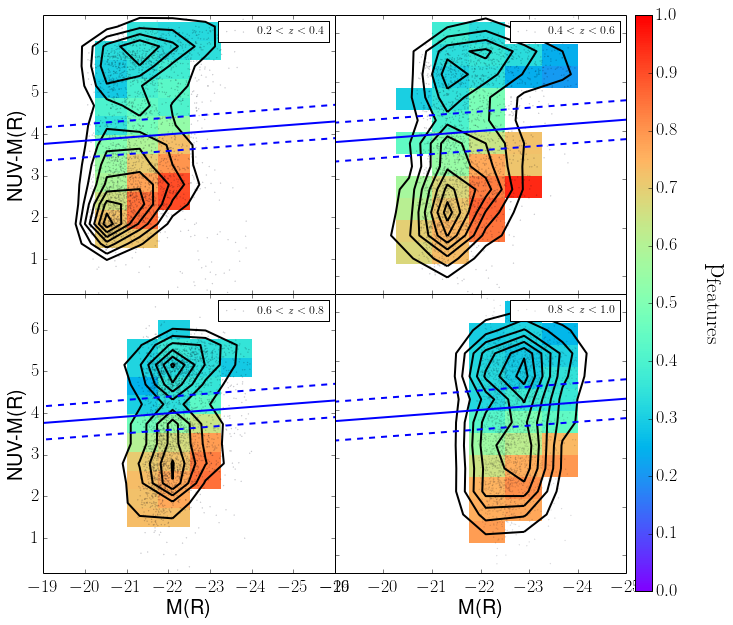

In [64]:
data_list=[]
for i in range(0,len(z_edges)-1):
    data_list.append(redshift_bin_dct[z_edges[i],z_edges[i+1]])

def Hist3D(xedges,yedges,the_data,colorhist):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MNUV']-the_data['MR']>=yedges[i]) & (the_data['MNUV']-the_data['MR'] < yedges[i+1]) & (the_data['MR']>=xedges[j]) & (the_data['MR']<xedges[j+1])
            newmatrix[i,j]=np.average(the_data[data_i_j]['t01_smooth_or_features_a02_features_or_disk_best_fraction'])
    newmatrix=ma.masked_where(colorhist.T<20,newmatrix)
    return newmatrix

colorhist0,xedges,yedges = np.histogram2d(data[data_list[0]]['MR'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist0=Hist3D(xedges,yedges,data[data_list[0]],colorhist0)

colorhist1,xedges,yedges = np.histogram2d(data[data_list[1]]['MR'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist1=Hist3D(xedges,yedges,data[data_list[1]],colorhist1)

colorhist2,xedges,yedges = np.histogram2d(data[data_list[2]]['MR'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist2=Hist3D(xedges,yedges,data[data_list[2]],colorhist2)

colorhist3,xedges,yedges = np.histogram2d(data[data_list[3]]['MR'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist3=Hist3D(xedges,yedges,data[data_list[3]],colorhist3)

colorhist81,xedges,yedges = np.histogram2d(data[new_sample_mag_limited]['MR'],data[new_sample_mag_limited]['MNUV']-data[new_sample_mag_limited]['MR'],range=((-30,-15),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist81=Hist3D(xedges,yedges,data[new_sample_mag_limited],colorhist81)

mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(12,10))
gs=gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)

cmap=cm.rainbow
alpha=.3

gsx=[0,0,1,1]
gsy=[0,1,0,1]
labellist=[2,4,6,8]

x=np.linspace(-40,-10,10)
ax0=plt.subplot(gs[0,0])
plt.scatter(data[data_list[0]]['MR'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],s=.1,alpha=alpha,label='$0.2<z<0.4$')
plt.contour(colorhist0.T,extent=extent,colors='k',linewidths=2)
im0=ax0.imshow(this_hist0,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.tick_params(labelbottom='off')
plt.ylabel('NUV-M(R)',fontsize=20)
plt.legend()
plt.gca().invert_xaxis()

ax1=plt.subplot(gs[0,1])
plt.scatter(data[data_list[1]]['MR'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],s=.1,alpha=alpha,label='$0.4<z<0.6$')
plt.contour(colorhist1.T,extent=extent,colors='k',linewidths=2)
im1=ax1.imshow(this_hist1,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.tick_params(labelleft='off',labelbottom='off')
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.gca().invert_xaxis()
plt.legend()

ax2=plt.subplot(gs[1,0],sharex=ax0)
plt.scatter(data[data_list[2]]['MR'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],s=.1,alpha=alpha,label='$0.6<z<0.8$')
plt.contour(colorhist2.T,extent=extent,colors='k',linewidths=2)
im2=ax2.imshow(this_hist2,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.gca().invert_xaxis()
plt.ylabel('NUV-M(R)',fontsize=20)
plt.xlabel('M(R)',fontsize=20)
plt.legend()

ax3=plt.subplot(gs[1,1],sharex=ax1)
plt.scatter(data[data_list[3]]['MR'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],s=.1,alpha=.2,label='$0.8<z<1.0$')
plt.contour(colorhist3.T,extent=extent,colors='k',linewidths=2)
im3=ax3.imshow(this_hist3,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.tick_params(labelleft='off')

        
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-25,-19)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('M(R)',fontsize=20)


f.subplots_adjust(wspace=0, hspace=0,right=.8)
cbar_ax = f.add_axes([0.81, 0.1, 0.02, 0.8])
f.colorbar(im0, cax=cbar_ax)
f.text(0.9, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=30)

plt.savefig('color_mag_plot.png')

## Section 4b - Improve on Tom's method by doing a fit for each redshift bin

In [32]:
def pdf_model(x, mu1,sig1,mu2,sig2,al_1):
    return al_1*normpdf(x, mu1, sig1) + (1-al_1)*normpdf(x, mu2, sig2)
def fit_gaussian(data_list):
    ydata,xdata,hist=plt.hist(data_list,normed=True,histtype='step',alpha=.01)
    #xdata is bin edges, want bin centers
    x_newdata=[]
    for i in range(0,len(xdata)-1):
        x_newdata.append((xdata[i+1]-xdata[i])/2.+xdata[i])
    #now fit gaussian 
    try:
        popt, pcov = curve_fit(pdf_model, x_newdata, ydata)
        #plot fit
        x=np.linspace(0,7,100)
        y=pdf_model(x,popt[0],popt[1],popt[2],popt[3],popt[4])
        plt.plot(x,y,ls='dashed',c='m',lw=5)
    except RuntimeError:
        pass
    
    return None

def equation(p,x):
    return p[4] + p[3]*x + p[2]*x**2 + p[1]*x**3 + p[0]*x**4

def fit_poly(data_list):
    ydata,xdata,hist=plt.hist(data_list,normed=True,histtype='step',alpha=.01)
    #xdata is bin edges, want bin centers
    x_newdata=[]
    for i in range(0,len(xdata)-1):
        x_newdata.append((xdata[i+1]-xdata[i])/2.+xdata[i])
    #now fit polynomial 
    p=np.polyfit(x_newdata,ydata,4)
    x=np.linspace(0,7,100)
    y=polyval(p,x)
    plt.plot(x,y,c='k',ls='dWhether there should be a separate committee to discuss EEOAA issues, which
affect Faculty, Postdocs, Staff, Undergraduates etc, rather that only
graduate students, it is of course up to the Head, who decides the Committee
structure of the Department. The issue of replacing the Grievance Committee,
ashed',lw=5)
    root = poly1d(polyder(p)).r[1]
    plt.axvline(root)
    
    return root


/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


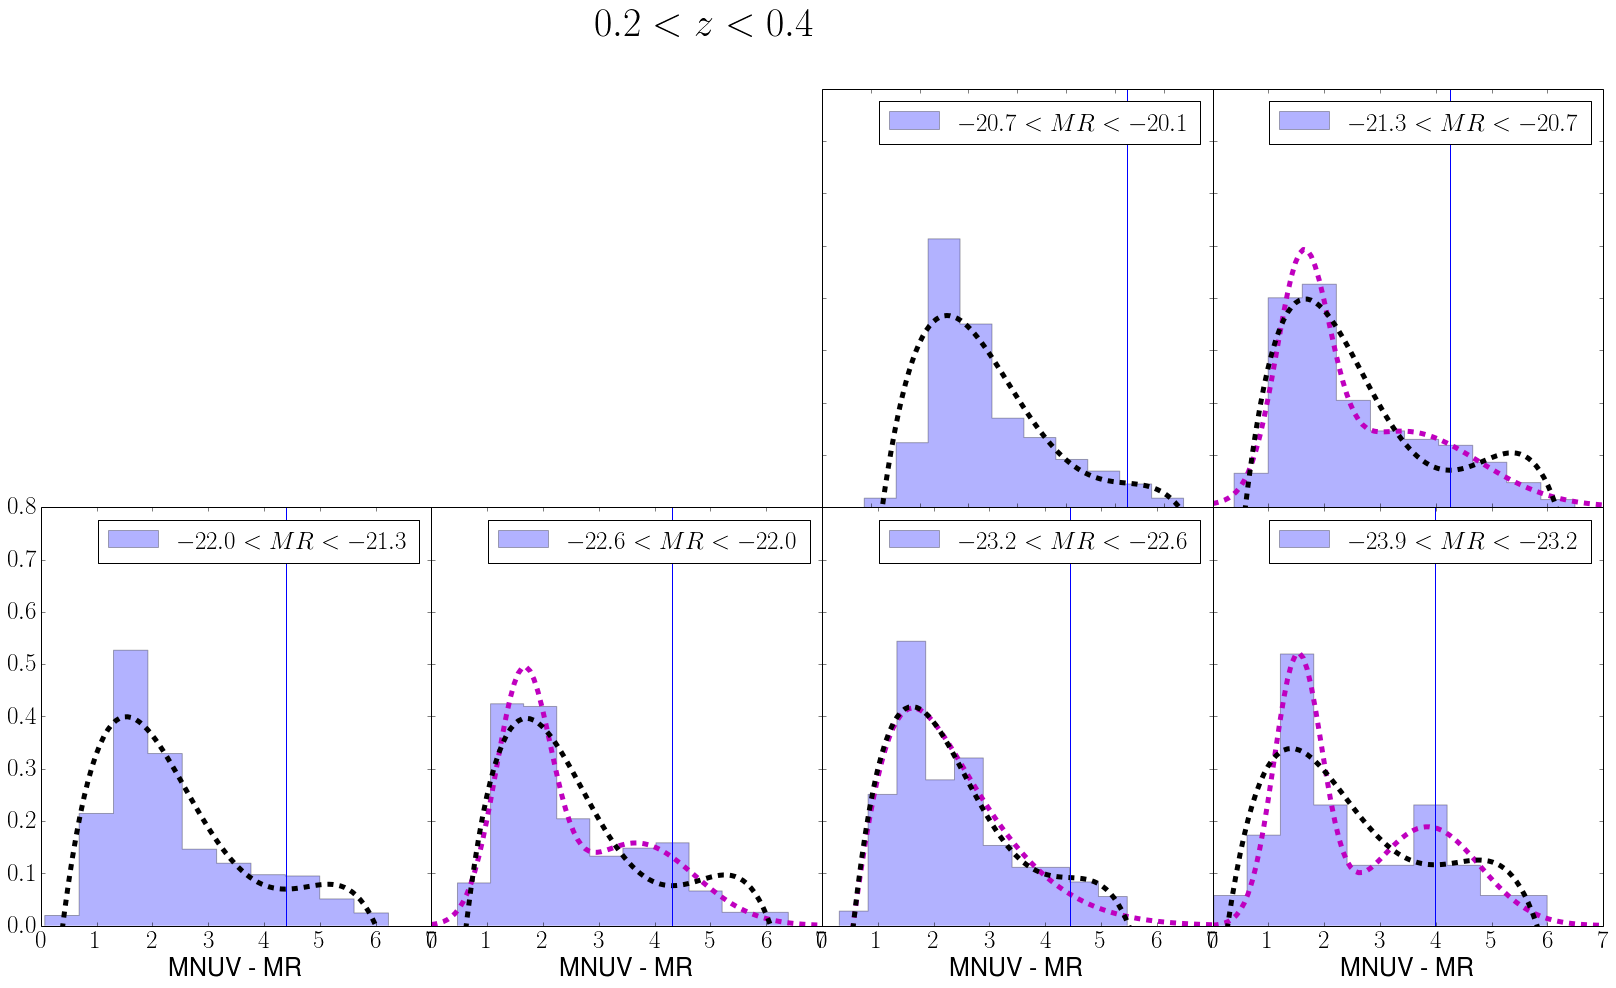

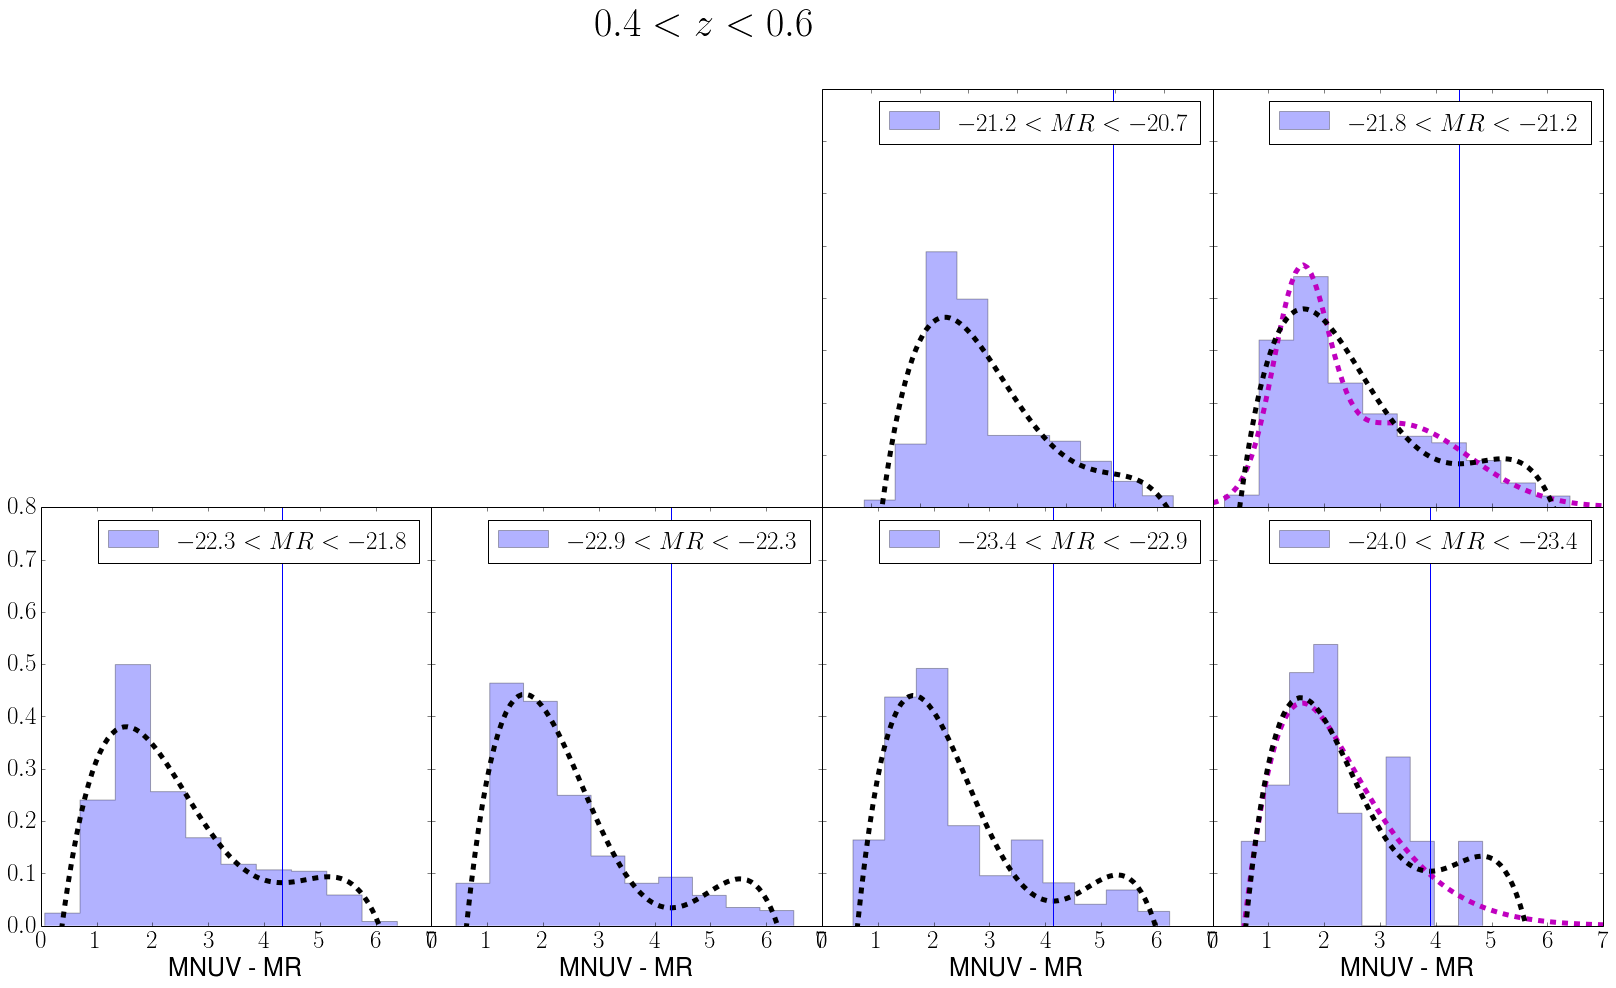

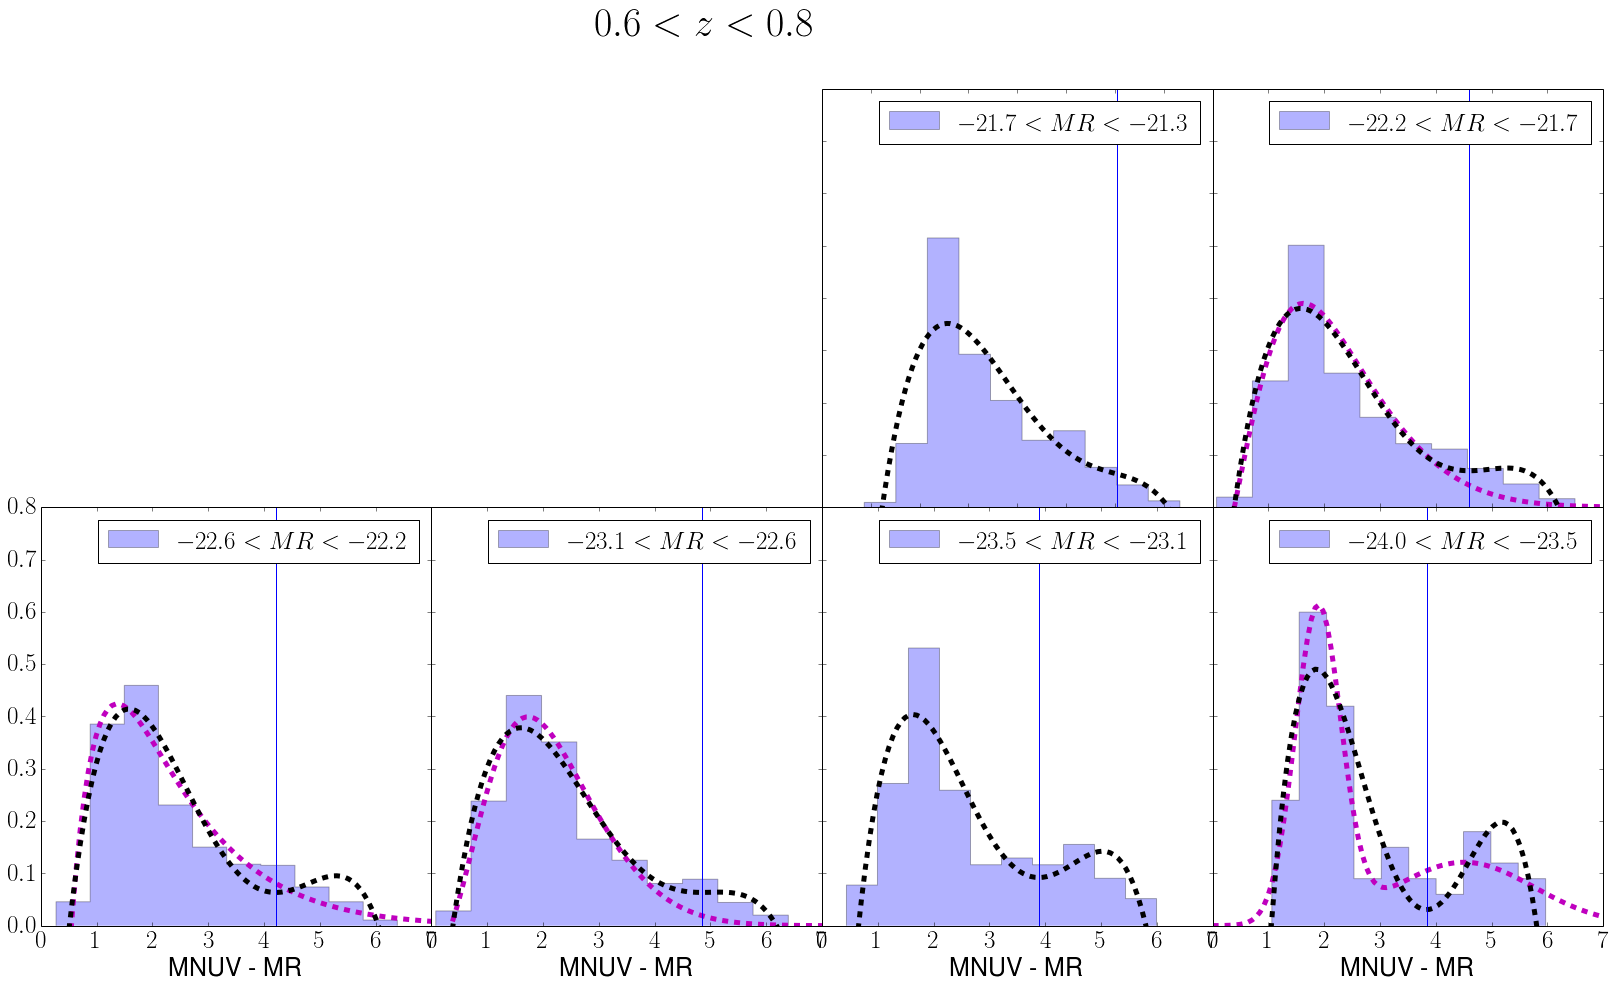

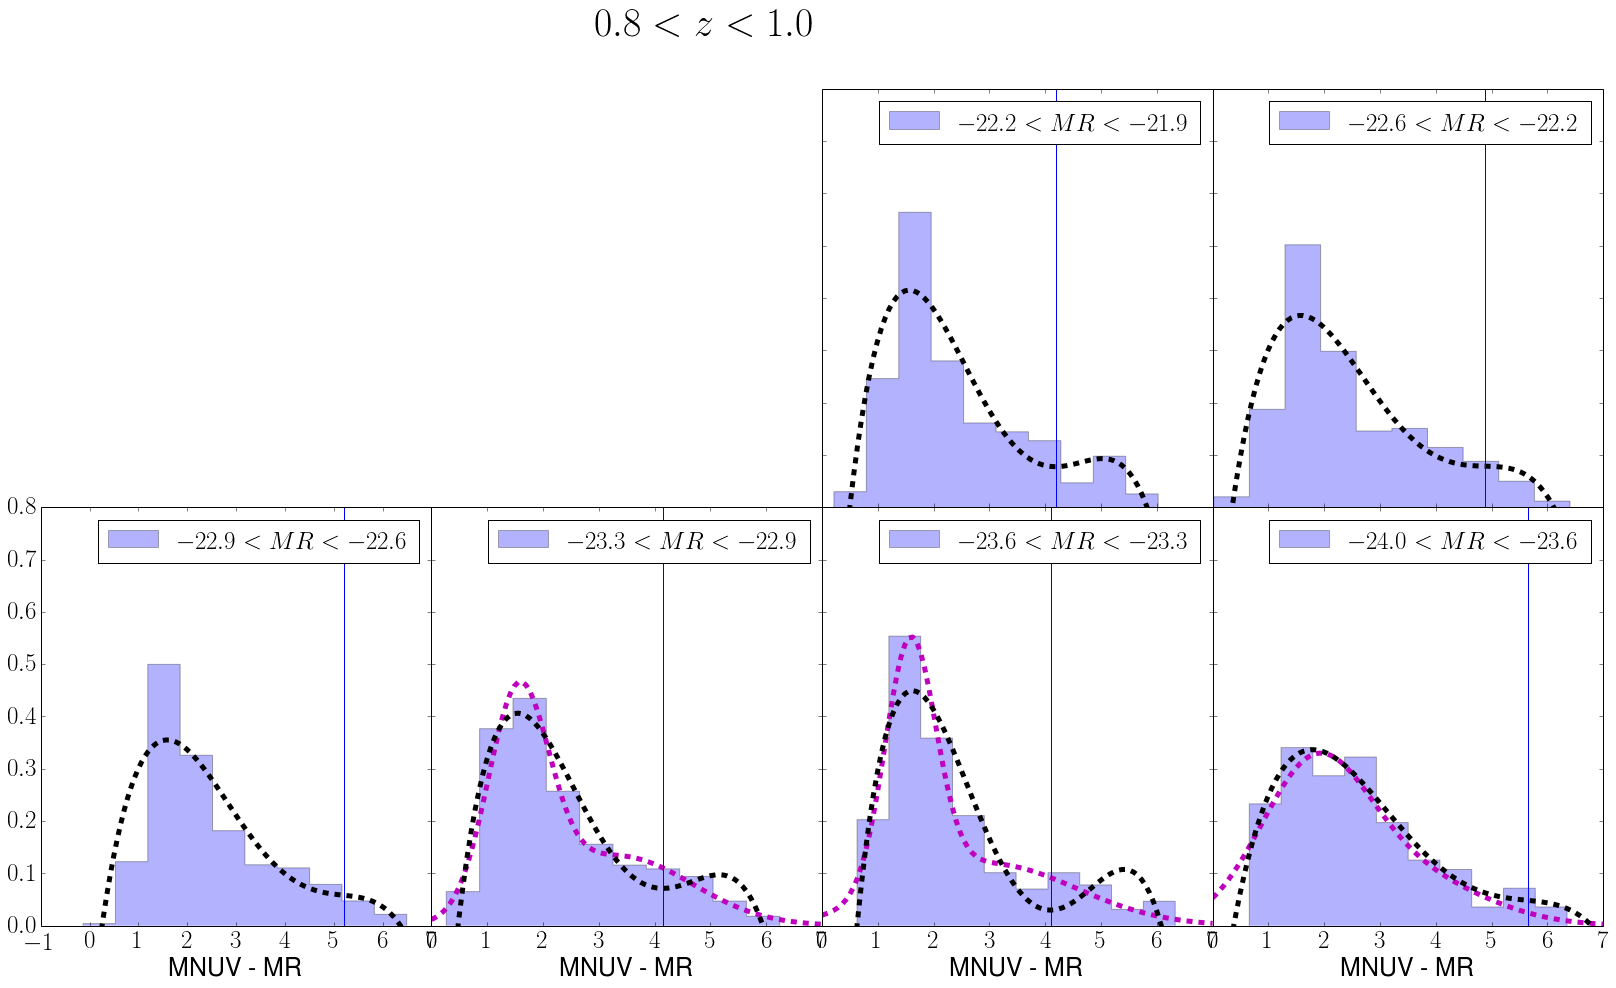

In [33]:
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

zl=0
zh=1

min_MR=np.min(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
max_MR=np.max(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
n_MR_bins=6
MR_edges=np.linspace(min_MR,max_MR,n_MR_bins+1)

MR_centers=[]
for i in range(0,len(MR_edges)-1):
    MR_centers.append((MR_edges[i+1]-MR_edges[i])/2.+MR_edges[i])
root_list=[]
    
gss=[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
gss=gss[::-1]

f=plt.figure(figsize=(28,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0,hspace=0)

for i in range(0,len(MR_edges)-1):
    ax0=plt.subplot(gs[gss[i]])
    data_this_bin=(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']>=MR_edges[i]) &  (data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']<MR_edges[i+1])
    data_list=data[data_this_bin]['MNUV']-data[data_this_bin]['MR']
    try: 
        plt.hist(data[data_this_bin]['MNUV']-data[data_this_bin]['MR'],histtype='step',fill='True',normed='True',color='k',alpha=.3,label='$%s<MR<%s$'%(round(MR_edges[i],1),round(MR_edges[i+1],1)))
        fit_gaussian(data_list)
    except ValueError:
        pass
    root_list.append(fit_poly(data_list))
    plt.ylim(0,.8)
    plt.legend(fontsize=25)
    
    if i!=3:
        plt.tick_params(labelleft='off')
    if i==7:
        plt.tick_params(labelleft='on')
    if i>3:
        plt.tick_params(labelbottom='off')
    if i<4:
        plt.xlabel('MNUV - MR',fontsize=25)
        
f.text(.4,.95,'$%s<z<%s$'%(z_edges[zl],z_edges[zh]),fontsize=40)
p_color_cut_2_4=np.polyfit(MR_centers[::-1],root_list[::-1],1)


mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

zl=1
zh=2

min_MR=np.min(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
max_MR=np.max(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
n_MR_bins=6
MR_edges=np.linspace(min_MR,max_MR,n_MR_bins+1)

MR_centers=[]
for i in range(0,len(MR_edges)-1):
    MR_centers.append((MR_edges[i+1]-MR_edges[i])/2.+MR_edges[i])
root_list=[]
    
gss=[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
gss=gss[::-1]

f=plt.figure(figsize=(28,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0,hspace=0)

for i in range(0,len(MR_edges)-1):
    ax0=plt.subplot(gs[gss[i]])
    data_this_bin=(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']>=MR_edges[i]) &  (data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']<MR_edges[i+1])
    data_list=data[data_this_bin]['MNUV']-data[data_this_bin]['MR']
    try: 
        plt.hist(data[data_this_bin]['MNUV']-data[data_this_bin]['MR'],histtype='step',fill='True',normed='True',color='k',alpha=.3,label='$%s<MR<%s$'%(round(MR_edges[i],1),round(MR_edges[i+1],1)))
        fit_gaussian(data_list)
    except ValueError:
        pass
    root_list.append(fit_poly(data_list))
    plt.ylim(0,.8)
    plt.legend(fontsize=25)
    
    if i!=3:
        plt.tick_params(labelleft='off')
    if i==7:
        plt.tick_params(labelleft='on')
    if i>3:
        plt.tick_params(labelbottom='off')
    if i<4:
        plt.xlabel('MNUV - MR',fontsize=25)
        
f.text(.4,.95,'$%s<z<%s$'%(z_edges[zl],z_edges[zh]),fontsize=40)
p_color_cut_4_6=np.polyfit(MR_centers[::-1],root_list[::-1],1)


mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

zl=2
zh=3

min_MR=np.min(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
max_MR=np.max(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
n_MR_bins=6
MR_edges=np.linspace(min_MR,max_MR,n_MR_bins+1)

MR_centers=[]
for i in range(0,len(MR_edges)-1):
    MR_centers.append((MR_edges[i+1]-MR_edges[i])/2.+MR_edges[i])
root_list=[]
    
gss=[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
gss=gss[::-1]

f=plt.figure(figsize=(28,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0,hspace=0)

for i in range(0,len(MR_edges)-1):
    ax0=plt.subplot(gs[gss[i]])
    data_this_bin=(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']>=MR_edges[i]) &  (data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']<MR_edges[i+1])
    data_list=data[data_this_bin]['MNUV']-data[data_this_bin]['MR']
    try: 
        plt.hist(data[data_this_bin]['MNUV']-data[data_this_bin]['MR'],histtype='step',fill='True',normed='True',color='k',alpha=.3,label='$%s<MR<%s$'%(round(MR_edges[i],1),round(MR_edges[i+1],1)))
        fit_gaussian(data_list)
    except ValueError:
        pass
    root_list.append(fit_poly(data_list))
    plt.ylim(0,.8)
    plt.legend(fontsize=25)
    
    if i!=3:
        plt.tick_params(labelleft='off')
    if i==7:
        plt.tick_params(labelleft='on')
    if i>3:
        plt.tick_params(labelbottom='off')
    if i<4:
        plt.xlabel('MNUV - MR',fontsize=25)
        
f.text(.4,.95,'$%s<z<%s$'%(z_edges[zl],z_edges[zh]),fontsize=40)
p_color_cut_6_8=np.polyfit(MR_centers[::-1],root_list[::-1],1)


mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsizde'] = 25 

zl=3
zh=4

min_MR=np.min(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
max_MR=np.max(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR'])
n_MR_bins=6
MR_edges=np.linspace(min_MR,max_MR,n_MR_bins+1)

MR_centers=[]
for i in range(0,len(MR_edges)-1):
    MR_centers.append((MR_edges[i+1]-MR_edges[i])/2.+MR_edges[i])
root_list=[]
    
gss=[(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
gss=gss[::-1]

f=plt.figure(figsize=(28,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0,hspace=0)

for i in range(0,len(MR_edges)-1):
    ax0=plt.subplot(gs[gss[i]])
    data_this_bin=(data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']>=MR_edges[i]) &  (data[redshift_bin_dct[z_edges[zl],z_edges[zh]]]['MR']<MR_edges[i+1])
    data_list=data[data_this_bin]['MNUV']-data[data_this_bin]['MR']
    try: 
        plt.hist(data[data_this_bin]['MNUV']-data[data_this_bin]['MR'],histtype='step',fill='True',normed='True',color='k',alpha=.3,label='$%s<MR<%s$'%(round(MR_edges[i],1),round(MR_edges[i+1],1)))
        fit_gaussian(data_list)
    except ValueError:
        pass
    root_list.append(fit_poly(data_list))
    plt.ylim(0,.8)
    plt.legend(fontsize=25)
    
    if i!=3:
        plt.tick_params(labelleft='off')
    if i==7:
        plt.tick_params(labelleft='on')
    if i>3:
        plt.tick_params(labelbottom='off')
    if i<4:
        plt.xlabel('MNUV - MR',fontsize=25)
        
f.text(.4,.95,'$%s<z<%s$'%(z_edges[zl],z_edges[zh]),fontsize=40)
p_color_cut_8_1=np.polyfit(MR_centers[::-1],root_list[::-1],1)


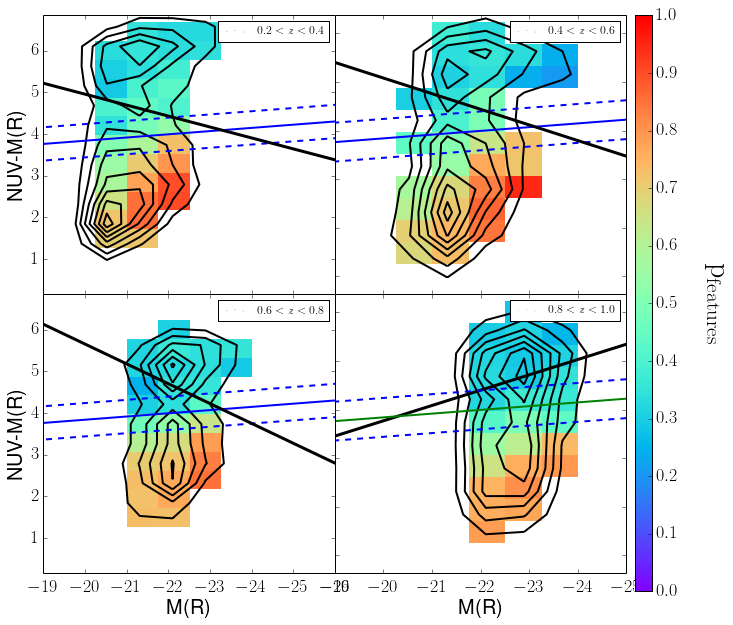

In [165]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(12,10))
gs=gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)

cmap=cm.rainbow
alpha=.3

gsx=[0,0,1,1]
gsy=[0,1,0,1]
labellist=[2,4,6,8]

x=np.linspace(-40,-10,10)
ax0=plt.subplot(gs[0,0])
plt.scatter(data[data_list[0]]['MR'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],s=.1,alpha=alpha,label='$0.2<z<0.4$')
plt.contour(colorhist0.T,extent=extent,colors='k',linewidths=2)
im0=ax0.imshow(this_hist0,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b') 
plt.plot(x,polyval(p_color_cut_2_4,x),c='k',lw=3)
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.tick_params(labelbottom='off')
plt.ylabel('NUV-M(R)',fontsize=20)
plt.legend()
plt.gca().invert_xaxis()

ax1=plt.subplot(gs[0,1])
plt.scatter(data[data_list[1]]['MR'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],s=.1,alpha=alpha,label='$0.4<z<0.6$')
plt.contour(colorhist1.T,extent=extent,colors='k',linewidths=2)
im1=ax1.imshow(this_hist1,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.tick_params(labelleft='off',labelbottom='off')
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')
plt.plot(x,polyval(p_color_cut_4_6,x),c='k',lw=3)

plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.gca().invert_xaxis()
plt.legend()

ax2=plt.subplot(gs[1,0],sharex=ax0)
plt.scatter(data[data_list[2]]['MR'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],s=.1,alpha=alpha,label='$0.6<z<0.8$')
plt.contour(colorhist2.T,extent=extent,colors='k',linewidths=2)
im2=ax2.imshow(this_hist2,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.plot(x,polyval(p_color_cut_6_8,x),c='k',lw=3)
plt.gca().invert_xaxis()
plt.ylabel('NUV-M(R)',fontsize=20)
plt.xlabel('M(R)',fontsize=20)

plt.legend()

ax3=plt.subplot(gs[1,1],sharex=ax1)
plt.scatter(data[data_list[3]]['MR'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],s=.1,alpha=.2,label='$0.8<z<1.0$')
plt.contour(colorhist3.T,extent=extent,colors='k',linewidths=2)
im3=ax3.imshow(this_hist3,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.tick_params(labelleft='off')
plt.plot(x,polyval(p_color_cut_8_1,x),c='k',lw=3)

        
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-25,-19)
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel('M(R)',fontsize=20)


f.subplots_adjust(wspace=0, hspace=0,right=.8)
cbar_ax = f.add_axes([0.81, 0.1, 0.02, 0.8])
f.colorbar(im0, cax=cbar_ax)
f.text(0.9, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=30)

# Section 4c - Trial 3 of isolating red sequence
## Claudia suggested using the technique of van der wel 2015 using U-V and V-J colors. I haven't fully deduced why this is better; will update once I have an idea. http://arxiv.org/abs/1404.2844

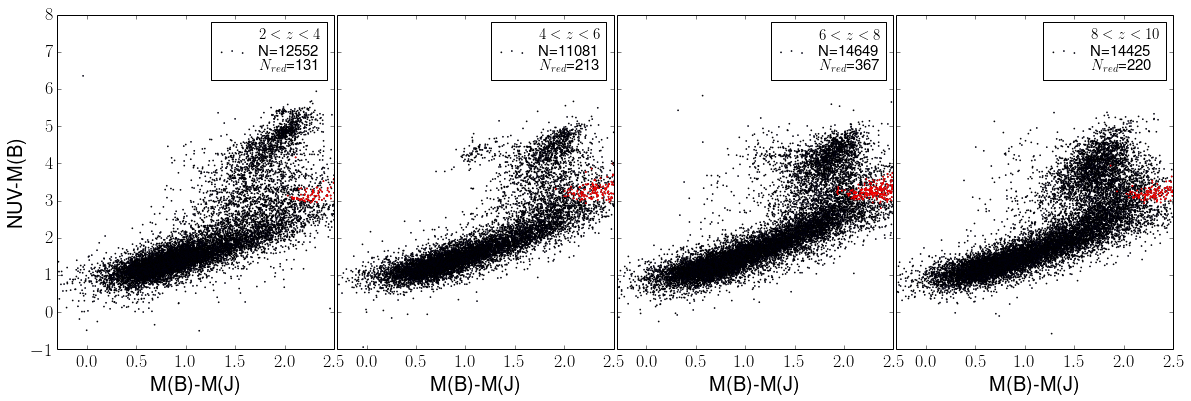

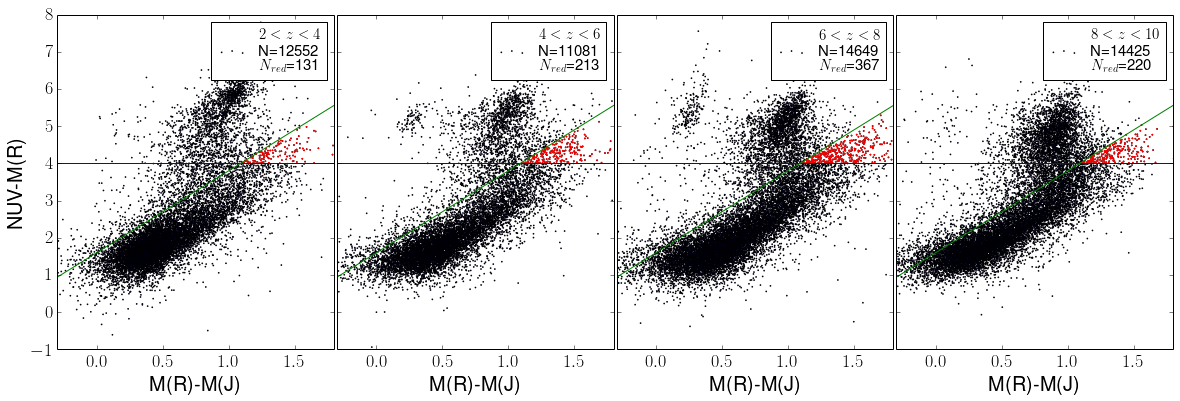

In [11]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(20,6))
gs=gridspec.GridSpec(1,4)
gs.update(wspace=.01)

data_list=[data_2_4,data_4_6,data_6_8,data_8_1]
data_list_red=[data_2_4_red,data_4_6_red,data_6_8_red,data_8_1_red]

labellist=[2,4,6,8]

x=np.linspace(-1,2,10)
for i in range(0,4):
    ax=plt.subplot(gs[0,i])
    plt.scatter(data[data_list[i]]['MB']-data[data_list[i]]['MJ'],data[data_list[i]]['MNUV']-data[data_list[i]]['MB'],s=.5,label='$%s<z<%s$\nN=%s\n$N_{red}$=%s'%(labellist[i],labellist[i]+2,len(data[data_list[i]]),len(data[data_list_red[i]])))
    plt.scatter(data[data_list_red[i]]['MB']-data[data_list_red[i]]['MJ'],data[data_list_red[i]]['MNUV']-data[data_list_red[i]]['MB'],s=.5,color='r')

    if i!=0:
        plt.tick_params(labelleft='off')
    plt.xlim(-.3,2.5)
    plt.ylim(-1,8)
    plt.xlabel('M(B)-M(J)',fontsize=20)
    if i==0:
        plt.ylabel('NUV-M(B)',fontsize=20)
    plt.legend(numpoints=1,fontsize=15)
    #plt.plot(x,4+0*x)
    #plt.plot(x,1.6+2.2*x)
    
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(20,6))
gs=gridspec.GridSpec(1,4)
gs.update(wspace=.01)

data_list=[data_2_4,data_4_6,data_6_8,data_8_1]
data_list_red=[data_2_4_red,data_4_6_red,data_6_8_red,data_8_1_red]

labellist=[2,4,6,8]

x=np.linspace(-1,2,10)
for i in range(0,4):
    ax=plt.subplot(gs[0,i])
    plt.scatter(data[data_list[i]]['MR']-data[data_list[i]]['MJ'],data[data_list[i]]['MNUV']-data[data_list[i]]['MR'],s=.5,label='$%s<z<%s$\nN=%s\n$N_{red}$=%s'%(labellist[i],labellist[i]+2,len(data[data_list[i]]),len(data[data_list_red[i]])))
    plt.scatter(data[data_list_red[i]]['MR']-data[data_list_red[i]]['MJ'],data[data_list_red[i]]['MNUV']-data[data_list_red[i]]['MR'],s=.5,color='r')

    if i!=0:
        plt.tick_params(labelleft='off')
    plt.xlim(-.3,1.8)
    plt.ylim(-1,8)
    plt.xlabel('M(R)-M(J)',fontsize=20)
    if i==0:
        plt.ylabel('NUV-M(R)',fontsize=20)
    plt.legend(numpoints=1,fontsize=15)
    plt.plot(x,4+0*x)
    plt.plot(x,1.6+2.2*x)





In [9]:
red_sequence = (data['Z']>=0.2) & (data['Z']<=1) & red_cut & mag_cut & (data['MNUV']-data['MR']>(2.7-.077*data['MR'])) 
blue_cloud = (data['Z']>=0.2) & (data['Z']<=1) & red_cut & mag_cut & (data['MNUV']-data['MR']<(1.9-.077*data['MR'])) 


In [74]:
def plot_red_fraction(p_min,p_max):
    disk_cut_weighted = (data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']>=p_min) & (data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']<p_max)
    disk_cut_debiased = (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=p_min) & (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']<p_max) & correctable_data
    disk_cut_best = (data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=p_min) & (data['t01_smooth_or_features_a02_features_or_disk_best_fraction']<p_max)


    all_disks_dct_weighted={}
    red_sequence_disks_dct_weighted={}
    for z in range(0,len(z_edges)-1):
        all_disks_dct_weighted[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut & disk_cut_weighted
        red_sequence_disks_dct_weighted[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut & red_sequence & disk_cut_weighted

    #only correctable stuff
    all_disks_dct_debiased={}
    red_sequence_disks_dct_debiased={}
    for z in range(0,len(z_edges)-1):
        all_disks_dct_debiased[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut  & disk_cut_debiased
        red_sequence_disks_dct_debiased[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) & red_cut & mag_cut & red_sequence & disk_cut_debiased

    #all stuff, but use best value 
    all_disks_dct_best={}
    red_sequence_disks_dct_best={}
    for z in range(0,len(z_edges)-1):
        all_disks_dct_best[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1]))  & red_cut & mag_cut  & disk_cut_best
        red_sequence_disks_dct_best[z_edges[z],z_edges[z+1]] = (data['Z']>=float(z_edges[z])) & (data['Z']<float(z_edges[z+1])) &  red_cut & mag_cut & red_sequence & disk_cut_best


    red_list = [.3,.5,.7,.9]

    colors=['r','g','b']
    fmt='--o'
    c=.95
    ms=10
    lw=4
    frac_list=[]
    yerr_low=[]
    yerr_hi=[]
    for z in range(0,len(z_edges)-1):
        N_all_disks = len(data[all_disks_dct_weighted[z_edges[z],z_edges[z+1]]]) #n
        N_red_disks = len(data[red_sequence_disks_dct_weighted[z_edges[z],z_edges[z+1]]]) #k
        try:
            frac = float(N_red_disks)/N_all_disks
            frac_list.append(frac)
        except ZeroDivisionError:
            frac_list.append(0)
        p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        yerr_low.append(frac-p_l)
        yerr_hi.append(p_u-frac)
    plt.errorbar(red_list,frac_list,yerr=(yerr_low,yerr_hi),c=colors[0],label='weighted',fmt=fmt,ms=ms,lw=lw)

    frac_list=[]
    yerr_low=[]
    yerr_hi=[]
    for z in range(0,len(z_edges)-1):
        N_all_disks = len(data[all_disks_dct_debiased[z_edges[z],z_edges[z+1]]]) #n
        N_red_disks = len(data[red_sequence_disks_dct_debiased[z_edges[z],z_edges[z+1]]]) #k
        
        try:
            frac = float(N_red_disks)/N_all_disks
            frac_list.append(frac)
        except ZeroDivisionError:
            frac_list.append(0)
            
        p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        yerr_low.append(frac-p_l)
        yerr_hi.append(p_u-frac)
    plt.errorbar(red_list,frac_list,yerr=(yerr_low,yerr_hi),c=colors[1],label='debiased',fmt=fmt,ms=ms,lw=lw)

    frac_list=[]
    yerr_low=[]
    yerr_hi=[]
    for z in range(0,len(z_edges)-1):
        N_all_disks = len(data[all_disks_dct_best[z_edges[z],z_edges[z+1]]]) #n
        N_red_disks = len(data[red_sequence_disks_dct_best[z_edges[z],z_edges[z+1]]]) #k
        try:
            frac = float(N_red_disks)/N_all_disks
            frac_list.append(frac)
        except ZeroDivisionError:
            frac_list.append(0)
    
        p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        yerr_low.append(frac-p_l)
        yerr_hi.append(p_u-frac)
    plt.errorbar(red_list,frac_list,yerr=(yerr_low,yerr_hi),c=colors[2],label='best',fmt=fmt,ms=ms,lw=lw)
    plt.xlim(.2,1)
    #plt.ylim(0,.55)
    #plt.xlabel('redshift',fontsize=20)
    #plt.ylabel('red~disks/all~disks',fontsize=20)
    plt.title('$\mathrm{%s<p_{ftr}<%s}$'%(p_min,p_max),fontsize=35)



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


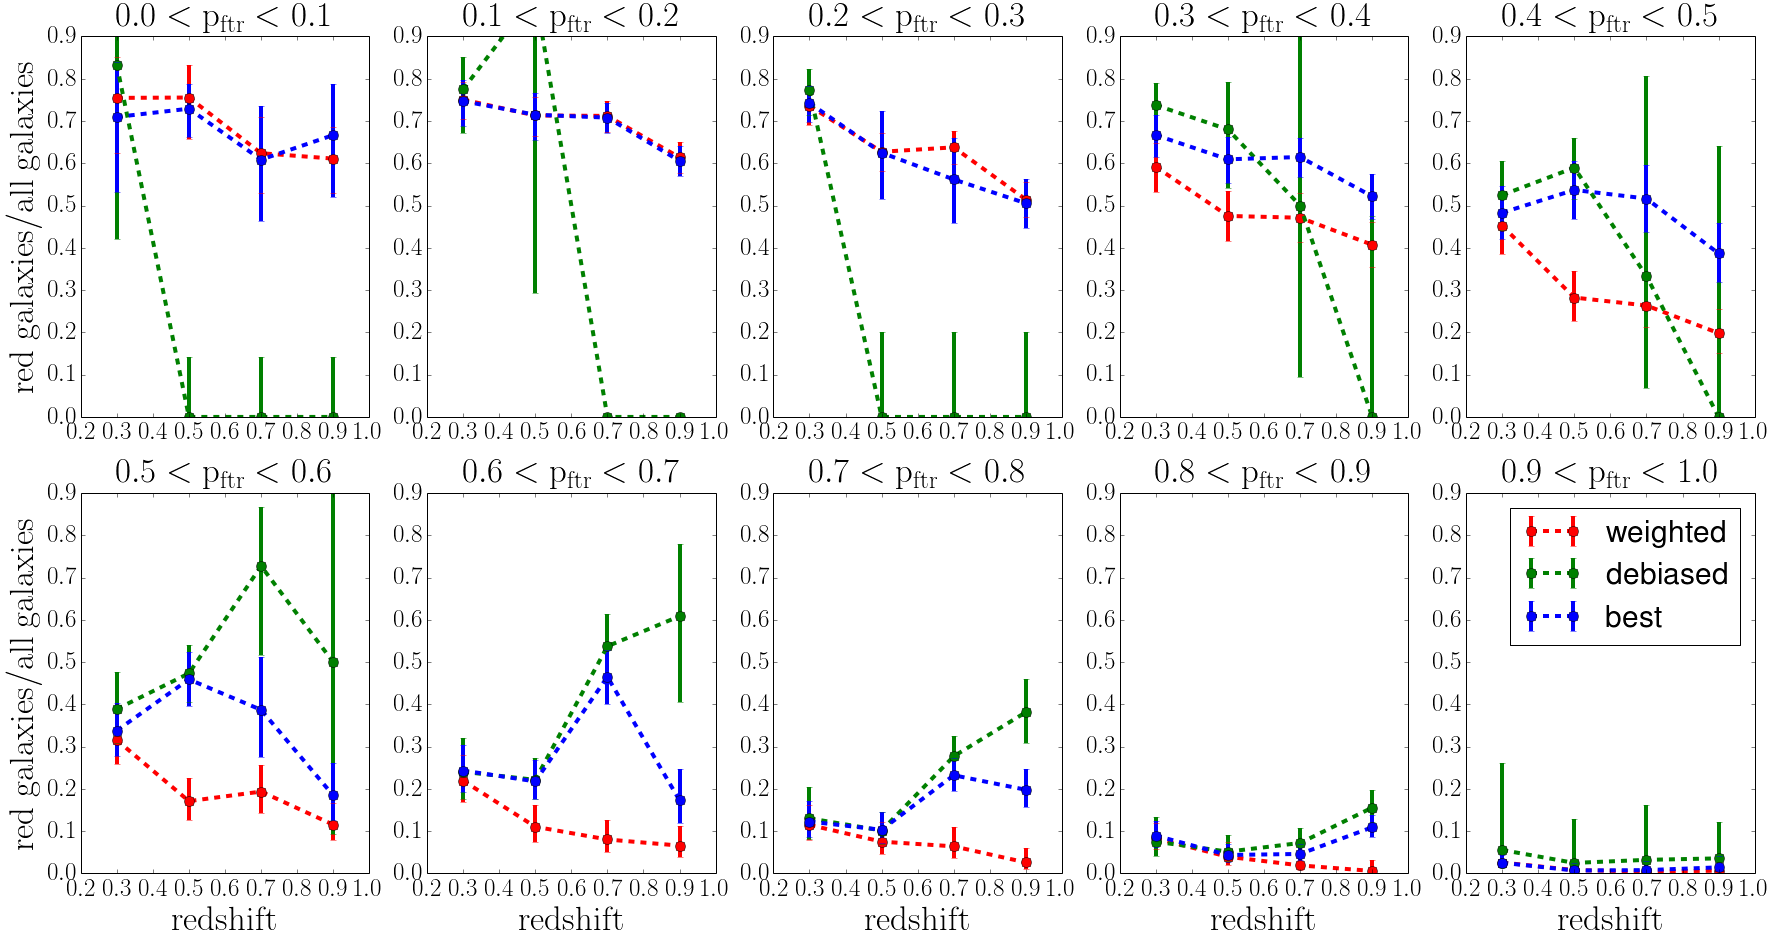

In [76]:
f=plt.figure(figsize=(30,15))
gs=gridspec.GridSpec(2,5)
#gs.update(wspace=0,hspace=0)

mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 

gss=[(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]

for i in range(0,len(gss)):
    ax=plt.subplot(gs[gss[i]])
    plot_red_fraction(round(i/10.,2),round((i+1)/10.,2))
    if i>4:
        plt.xlabel('$\mathrm{redshift}$',fontsize=35)
    if i==0:
        plt.ylabel('$\mathrm{red~galaxies/all~galaxies}$',fontsize=35)
    if i==5:
        plt.ylabel('$\mathrm{red~galaxies/all~galaxies}$',fontsize=35)
    if i==9:
        plt.legend(fontsize=30)
    plt.ylim(0,.9)

plt.savefig('disk_fraction_p_bins.png')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


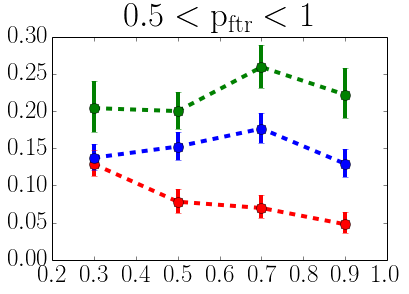

In [79]:
plot_red_fraction(.5,1)


In [68]:
disk_cut_debiased = (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']>=0) & (data['t01_smooth_or_features_a02_features_or_disk_debiased_fraction']<.1) & correctable_data


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


(array([  1.,   0.,   2.,   4.,   7.,   6.,   7.,   9.,  15.,  16.]),
 array([ 0.0384667 ,  0.04461534,  0.05076398,  0.05691262,  0.06306126,
         0.06920991,  0.07535855,  0.08150719,  0.08765583,  0.09380447,
         0.09995311]),
 <a list of 10 Patch objects>)

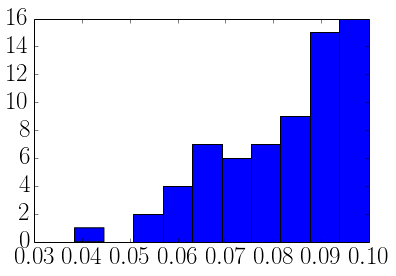

In [69]:
plt.hist(data[disk_cut_debiased]['t01_smooth_or_features_a02_features_or_disk_debiased_fraction'])

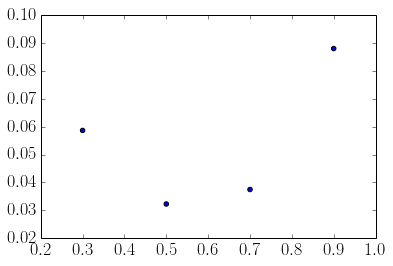

In [23]:
#red disks / all disks, using weighted values to identify disks
#complication: missing a lot of disks. which ones? if color is correlated with magnitude, then we'd be losing 
#the fainter disks, which would be the blue ones: f = N_red / (N_red + N_blue).  
#by adding more faint disks, we'd have more blue disks, so this should decrease the fractions... hmm 

In [ ]:
p_l=dist.beta.ppf((1-c)/2.,k+1,n-k+1)
p_u=dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)

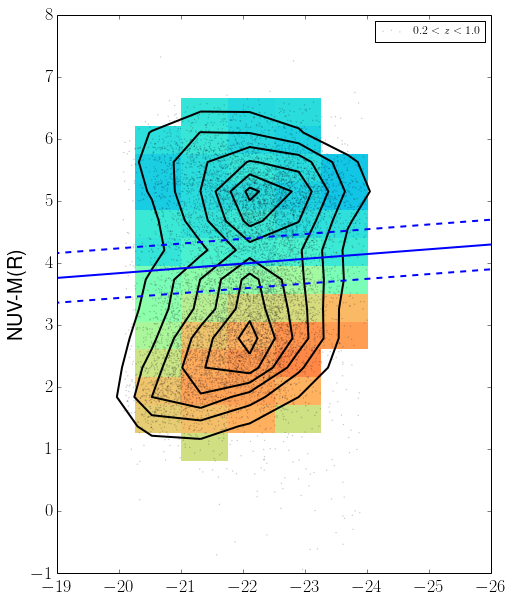

In [29]:
f=plt.figure(figsize=(10,10))
plt.scatter(data[new_sample_mag_limited]['MR'],data[new_sample_mag_limited]['MNUV']-data[new_sample_mag_limited]['MR'],s=.1,alpha=alpha,label='$0.2<z<1.0$')
plt.contour(colorhist81.T,extent=extent,colors='k',linewidths=2)
plt.imshow(this_hist81,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1)
plt.plot(x,2.3-.077*x,lw=2)    
plt.plot(x,1.9-.077*x,lw=2,ls='dashed',c='b')    
plt.plot(x,2.7-.077*x,lw=2,ls='dashed',c='b')    
plt.ylim(-1,8)
plt.xlim(-26,-19)
plt.ylabel('NUV-M(R)',fontsize=20)
plt.legend()
plt.gca().invert_xaxis()

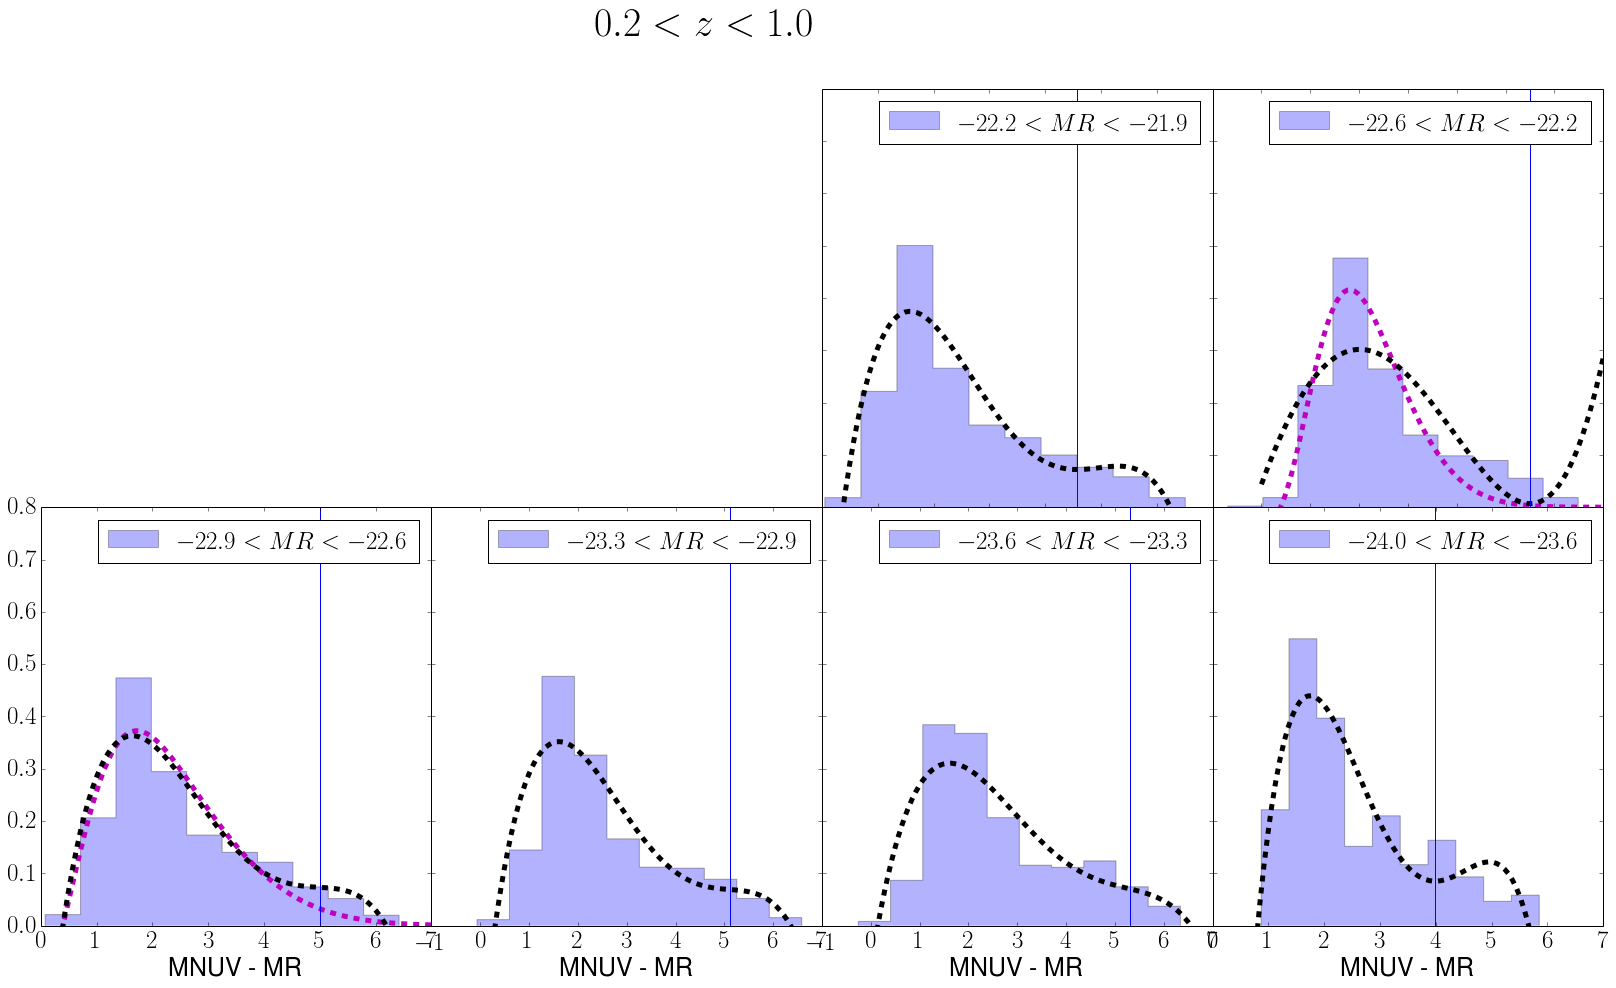

In [35]:
f=plt.figure(figsize=(28,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0,hspace=0)

for i in range(0,len(MR_edges)-1):
    ax0=plt.subplot(gs[gss[i]])
    data_this_bin=(data[new_sample_mag_limited]['MR']>=MR_edges[i]) &  (data[new_sample_mag_limited]['MR']<MR_edges[i+1])
    data_list=data[data_this_bin]['MNUV']-data[data_this_bin]['MR']
    try: 
        plt.hist(data[data_this_bin]['MNUV']-data[data_this_bin]['MR'],histtype='step',fill='True',normed='True',color='k',alpha=.3,label='$%s<MR<%s$'%(round(MR_edges[i],1),round(MR_edges[i+1],1)))
        fit_gaussian(data_list)
    except ValueError:
        pass
    root_list.append(fit_poly(data_list))
    plt.ylim(0,.8)
    plt.legend(fontsize=25)
    
    if i!=3:
        plt.tick_params(labelleft='off')
    if i==7:
        plt.tick_params(labelleft='on')
    if i>3:
        plt.tick_params(labelbottom='off')
    if i<4:
        plt.xlabel('MNUV - MR',fontsize=25)
        
f.text(.4,.95,'$%s<z<%s$'%(0.2,1.0),fontsize=40)


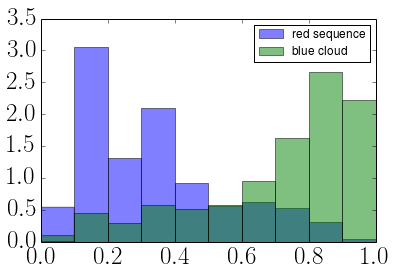

In [58]:
plt.hist(data[red_sequence]['t01_smooth_or_features_a02_features_or_disk_best_fraction'],normed=True,alpha=.5,label='red sequence',range=(0,1))
plt.hist(data[blue_cloud]['t01_smooth_or_features_a02_features_or_disk_best_fraction'],normed=True,alpha=.5,label='blue cloud',range=(0,1))
plt.legend()


In [57]:
red_sequence = (data['Z']>=0.2) & (data['Z']<=1) & red_cut & mag_cut  & (data['MNUV']-data['MR']>(2.7-.077*data['MR'])) 
blue_cloud = (data['Z']>=0.2) & (data['Z']<=1) & red_cut & mag_cut  & (data['MNUV']-data['MR']<(1.9-.077*data['MR'])) 


In [47]:
SB_cut = (data['MU_HI']<21)


In [66]:
data_list=[]
for i in range(0,len(z_edges)-1):
    data_list.append(redshift_bin_dct[z_edges[i],z_edges[i+1]])

def Hist3D(xedges,yedges,the_data,colorhist):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MNUV']-the_data['MR']>=yedges[i]) & (the_data['MNUV']-the_data['MR'] < yedges[i+1]) & (the_data['MR']-the_data['MJ']>=xedges[j]) & (the_data['MR']-the_data['MJ']<xedges[j+1])
            newmatrix[i,j]=np.average(the_data[data_i_j]['t01_smooth_or_features_a02_features_or_disk_best_fraction'])
    newmatrix=ma.masked_where(colorhist.T<20,newmatrix)
    return newmatrix

colorhist0,xedges,yedges = np.histogram2d(data[data_list[0]]['MR']-data[data_list[0]]['MJ'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],range=((-1,2),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist0=Hist3D(xedges,yedges,data[data_list[0]],colorhist0)

colorhist1,xedges,yedges = np.histogram2d(data[data_list[1]]['MR']-data[data_list[1]]['MJ'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],range=((-1,2),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist1=Hist3D(xedges,yedges,data[data_list[1]],colorhist1)

colorhist2,xedges,yedges = np.histogram2d(data[data_list[2]]['MR']-data[data_list[2]]['MJ'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],range=((-1,2),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist2=Hist3D(xedges,yedges,data[data_list[2]],colorhist2)

colorhist3,xedges,yedges = np.histogram2d(data[data_list[3]]['MR']-data[data_list[3]]['MJ'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],range=((-1,2),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist3=Hist3D(xedges,yedges,data[data_list[3]],colorhist3)



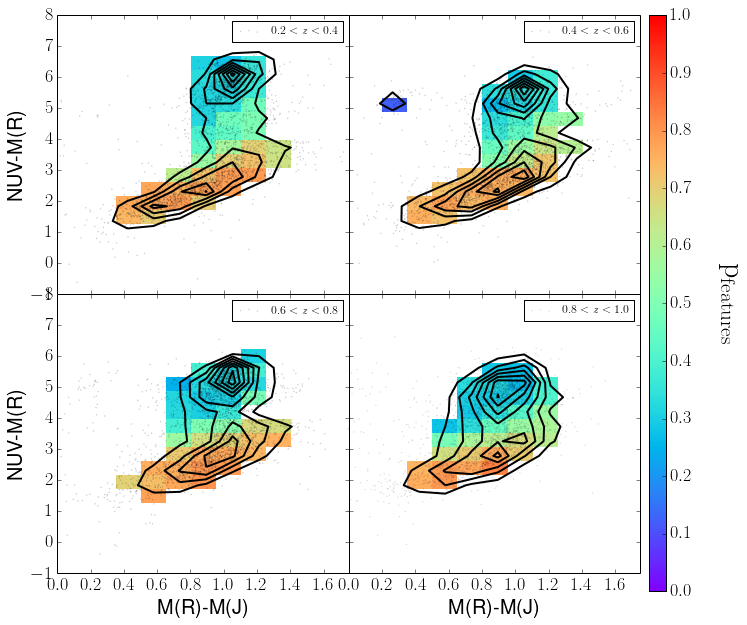

In [67]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(12,10))
gs=gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)

cmap=cm.rainbow
alpha=.3

gsx=[0,0,1,1]
gsy=[0,1,0,1]
labellist=[2,4,6,8]

ax0=plt.subplot(gs[0,0])
plt.scatter(data[data_list[0]]['MR']-data[data_list[0]]['MJ'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],s=.1,alpha=alpha,label='$0.2<z<0.4$')
plt.contour(colorhist0.T,extent=extent,colors='k',linewidths=2)
im0=ax0.imshow(this_hist0,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.xlim(0,2)
plt.ylim(0,7)
plt.tick_params(labelbottom='off')
plt.ylabel('NUV-M(R)',fontsize=20)
plt.legend()

ax1=plt.subplot(gs[0,1],sharey=ax0)
plt.scatter(data[data_list[1]]['MR']-data[data_list[1]]['MJ'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],s=.1,alpha=alpha,label='$0.4<z<0.6$')
plt.contour(colorhist1.T,extent=extent,colors='k',linewidths=2)
im1=ax1.imshow(this_hist1,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.tick_params(labelleft='off',labelbottom='off')
plt.legend()

ax2=plt.subplot(gs[1,0],sharex=ax0)
plt.scatter(data[data_list[2]]['MR']-data[data_list[2]]['MJ'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],s=.1,alpha=alpha,label='$0.6<z<0.8$')
plt.contour(colorhist2.T,extent=extent,colors='k',linewidths=2)
im2=ax2.imshow(this_hist2,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.xlim(0,1.75)
plt.ylabel('NUV-M(R)',fontsize=20)
plt.xlabel('M(R)-M(J)',fontsize=20)
plt.legend()

ax3=plt.subplot(gs[1,1],sharex=ax1,sharey=ax2)
plt.scatter(data[data_list[3]]['MR']-data[data_list[3]]['MJ'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],s=.1,alpha=.2,label='$0.8<z<1.0$')
plt.contour(colorhist3.T,extent=extent,colors='k',linewidths=2)
im3=ax3.imshow(this_hist3,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.xlim(0,1.75)
plt.tick_params(labelleft='off')

plt.legend()
plt.xlabel('M(R)-M(J)',fontsize=20)


f.subplots_adjust(wspace=0, hspace=0,right=.8)
cbar_ax = f.add_axes([0.81, 0.1, 0.02, 0.8])
f.colorbar(im0, cax=cbar_ax)
f.text(0.9, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=30)

plt.savefig('color_color_plot.png')

In [19]:
data_list=[]
for i in range(0,len(z_edges)-1):
    data_list.append(redshift_bin_dct[z_edges[i],z_edges[i+1]])

def Hist3D(xedges,yedges,the_data,colorhist):
    newmatrix = np.zeros(shape=(len(yedges)-1,len(xedges)-1))
    for i in range(0,len(yedges)-1):
        for j in range(0,len(xedges)-1):
            data_i_j = (the_data['MNUV']-the_data['MR']>=yedges[i]) & (the_data['MNUV']-the_data['MR'] < yedges[i+1]) & (the_data['mass_med']>=xedges[j]) & (the_data['mass_med']<xedges[j+1])
            newmatrix[i,j]=np.average(the_data[data_i_j]['t01_smooth_or_features_a02_features_or_disk_best_fraction'])
    newmatrix=ma.masked_where(colorhist.T<20,newmatrix)
    return newmatrix

colorhist0,xedges,yedges = np.histogram2d(data[data_list[0]]['mass_med'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],range=((6,13),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist0=Hist3D(xedges,yedges,data[data_list[0]],colorhist0)

colorhist1,xedges,yedges = np.histogram2d(data[data_list[1]]['mass_med'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],range=((6,13),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist1=Hist3D(xedges,yedges,data[data_list[1]],colorhist1)

colorhist2,xedges,yedges = np.histogram2d(data[data_list[2]]['mass_med'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],range=((6,13),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist2=Hist3D(xedges,yedges,data[data_list[2]],colorhist2)

colorhist3,xedges,yedges = np.histogram2d(data[data_list[3]]['mass_med'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],range=((6,13),(-1,8)),bins=(20,20))
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
this_hist3=Hist3D(xedges,yedges,data[data_list[3]],colorhist3)

/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


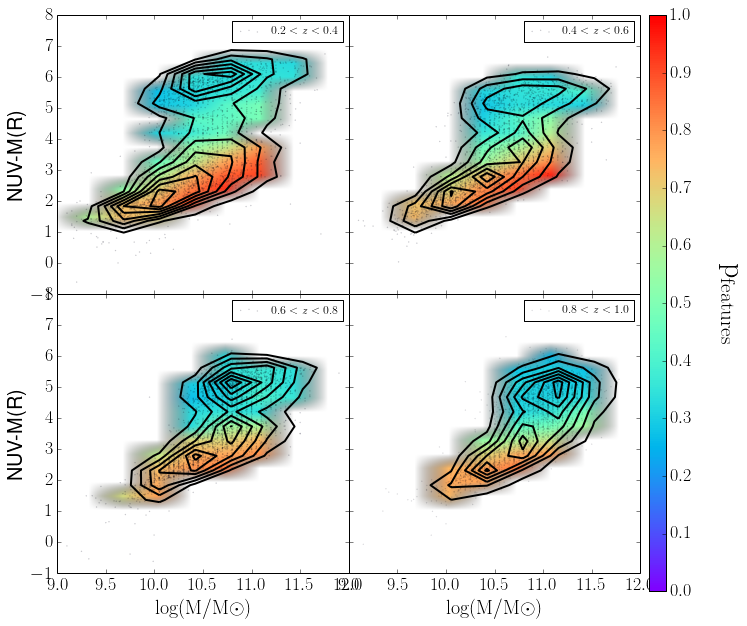

In [25]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

f=plt.figure(figsize=(12,10))
gs=gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)

cmap=cm.rainbow
alpha=.3

gsx=[0,0,1,1]
gsy=[0,1,0,1]
labellist=[2,4,6,8]

ax0=plt.subplot(gs[0,0])
plt.scatter(data[data_list[0]]['mass_med'],data[data_list[0]]['MNUV']-data[data_list[0]]['MR'],s=.1,alpha=alpha,label='$0.2<z<0.4$')
plt.contour(colorhist0.T,extent=extent,colors='k',linewidths=2)
im0=ax0.imshow(this_hist0,origin='lower',extent=extent,cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.xlim(9,12)
plt.ylim(0,7)
plt.tick_params(labelbottom='off')
plt.ylabel('NUV-M(R)',fontsize=20)
plt.legend()

ax1=plt.subplot(gs[0,1],sharey=ax0)
plt.scatter(data[data_list[1]]['mass_med'],data[data_list[1]]['MNUV']-data[data_list[1]]['MR'],s=.1,alpha=alpha,label='$0.4<z<0.6$')
plt.contour(colorhist1.T,extent=extent,colors='k',linewidths=2)
im1=ax1.imshow(this_hist1,origin='lower',extent=extent,cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.tick_params(labelleft='off',labelbottom='off')
plt.legend()

ax2=plt.subplot(gs[1,0],sharex=ax0)
plt.scatter(data[data_list[2]]['mass_med'],data[data_list[2]]['MNUV']-data[data_list[2]]['MR'],s=.1,alpha=alpha,label='$0.6<z<0.8$')
plt.contour(colorhist2.T,extent=extent,colors='k',linewidths=2)
im2=ax2.imshow(this_hist2,origin='lower',extent=extent,cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.xlim(9,12)
plt.ylabel('NUV-M(R)',fontsize=20)
plt.xlabel('$\mathrm{log(M/M\odot)}$',fontsize=20)
plt.legend()

ax3=plt.subplot(gs[1,1],sharex=ax1,sharey=ax2)
plt.scatter(data[data_list[3]]['mass_med'],data[data_list[3]]['MNUV']-data[data_list[3]]['MR'],s=.1,alpha=.2,label='$0.8<z<1.0$')
plt.contour(colorhist3.T,extent=extent,colors='k',linewidths=2)
im3=ax3.imshow(this_hist3,origin='lower',extent=extent,cmap=cmap,vmin=0,vmax=1,aspect='auto')
plt.xlim(9,12)
plt.tick_params(labelleft='off')

plt.legend()
plt.xlabel('$\mathrm{log(M/M\odot)}$',fontsize=20)


f.subplots_adjust(wspace=0, hspace=0,right=.8)
cbar_ax = f.add_axes([0.81, 0.1, 0.02, 0.8])
f.colorbar(im0, cax=cbar_ax)
f.text(0.9, 0.5, r'$\mathrm{p_{features}}$', ha='center', va='center', rotation=270,fontsize=30)

plt.savefig('color_mass_plot.png')

(array([  2.00000000e+00,   4.47000000e+02,   1.50100000e+03,
          6.56800000e+03,   1.86240000e+04,   2.14850000e+04,
          1.60940000e+04,   4.73400000e+03,   9.60000000e+01,
          6.00000000e+00]),
 array([  6. ,   6.7,   7.4,   8.1,   8.8,   9.5,  10.2,  10.9,  11.6,
         12.3,  13. ]),
 <a list of 10 Patch objects>)

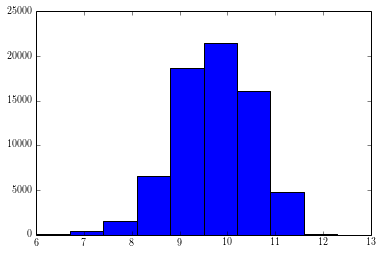

In [18]:
plt.hist(data['mass_med'],range=(6,13))